In [1]:
import pandas as pd
import seaborn as sns
sns.set()

df = pd.read_csv('https://raw.githubusercontent.com/open-covid-19/data/master/output/world.csv')
df['Confirmed'] = df['Confirmed'].astype(float)
df['Deaths'] = df['Deaths'].astype(float)
df = df.set_index('Date')

### Looking at the outbreak
There are months of data, but we only care about when the number of cases started to grow. We define *outbreak* as whenever the number of cases exceeded certain threshold. In this case, we are using 10.

In [2]:
def get_outbreak_mask(data: pd.DataFrame, threshold: int = 10):
    ''' Returns a mask for > N confirmed cases '''
    return data['Confirmed'] > threshold

In [3]:
code = 'IT'
cols = ['CountryCode', 'CountryName', 'Confirmed', 'Deaths']
country = df[df['CountryCode'] == code][cols]
country = country[get_outbreak_mask(country)]

### Plotting the data
Let's take a first look at the data. Here we are looking at the confirmed and fatal cases for Italy through March 14. 

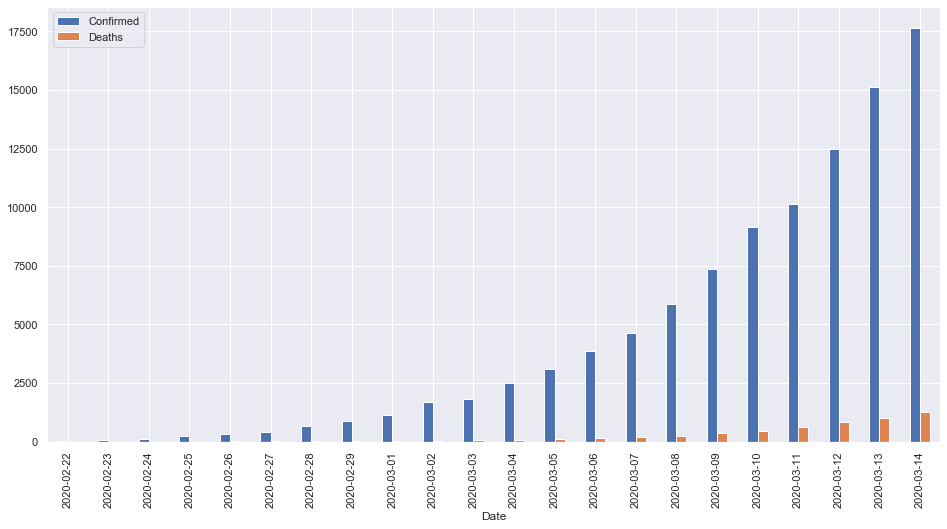

In [4]:
coumtry = country[country.index <= '2020-03-14']
country.plot(kind='bar', figsize=(16, 8));

### Modeling the data
The data appears to follow an exponential curve, it looks straight out of a middle school math textbook cover. Let's see if we can model it using some parameter fitting 

In [5]:
from scipy import optimize

def exponential_function(x: float, a: float, b: float, c: float):
    ''' a * (b ^ x) + c '''
    return a * (b ** x) + c

X, y = list(range(len(country))), country['Confirmed'].tolist()
params, _ = optimize.curve_fit(exponential_function, X, y)

print('Estimated function: {0:.3f} * ({1:.3f} ^ X) + {2:.3f}'.format(*params))

Estimated function: 480.670 * (1.190 ^ X) + -656.617


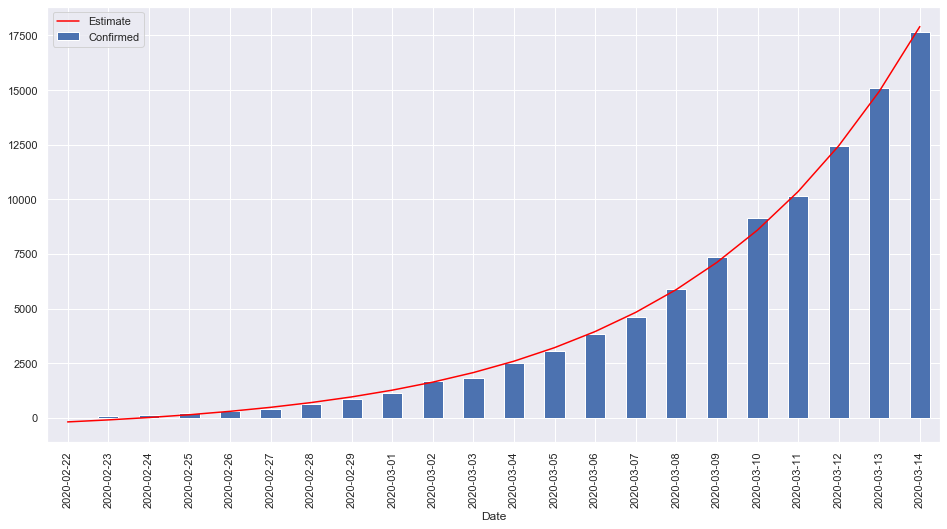

In [6]:
ax = country[['Confirmed']].plot(kind='bar', figsize=(16, 8))
estimate = [exponential_function(x, *params) for x in X]
ax.plot(country.index, estimate, color='red', label='Estimate')
ax.legend();

### Validating the model
That curve looks like a very good fit! Even though proper epidemiology models are fundamentally different (because diseases can't grow exponentially indefinitely), the exponential model should be good for short term predictions.

To validate our model, let's try to fit it again without looking at the last 3 days of data. Then, we can estimate the missing days using our model, and verify if the results still hold by comparing what the model thought was going to happen with the actual data.

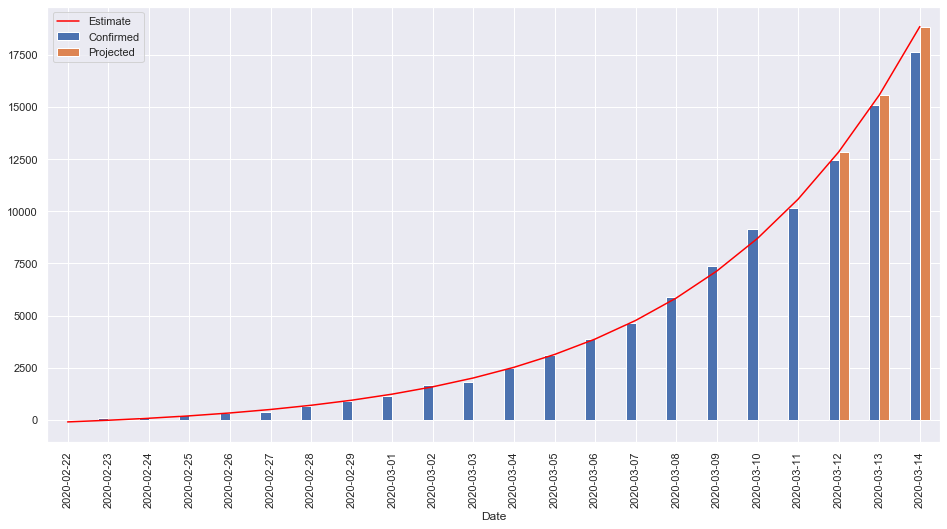

In [7]:
ESTIMATE_DAYS = 3
params_validate, _ = optimize.curve_fit(exponential_function, X[:-ESTIMATE_DAYS], y[:-ESTIMATE_DAYS])

# Project zero for all values except for the last ESTIMATE_DAYS
projected = [0] * len(X[:-ESTIMATE_DAYS]) + [exponential_function(x, *params_validate) for x in X[-ESTIMATE_DAYS:]]
projected = pd.Series(projected, index=country.index, name='Projected')
df_ = pd.DataFrame({'Confirmed': country['Confirmed'], 'Projected': projected})
ax = df_.plot(kind='bar', figsize=(16, 8))
estimate = [exponential_function(x, *params_validate) for x in X]
ax.plot(country.index, estimate, color='red', label='Estimate')
ax.legend();

### Projecting future data
It looks like our exponential model slightly overestimates the confirmed cases. That's a good sign! It means that the disease is slowing down a bit. The numbers are close enough that a 3-day projection is probably an accurate enough estimate.

Now, let's use the model we fitted earlier which used all the data, and try to predict what the next 3 days will look like.

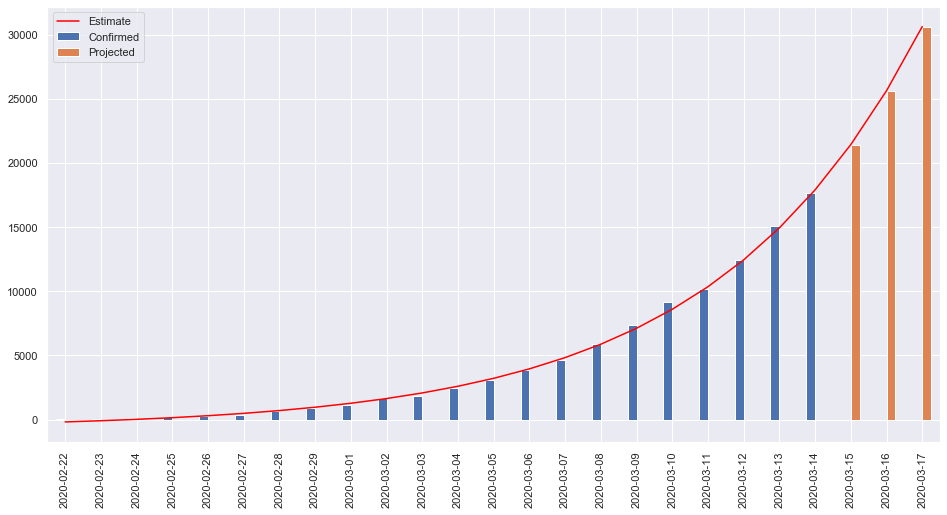

In [8]:
import datetime

FUTURE_DAYS = 3

# Append N new days to our indices
date_format = '%Y-%m-%d'
date_range = [datetime.datetime.strptime(date, date_format) for date in country.index]
for _ in range(FUTURE_DAYS): date_range.append(date_range[-1] + datetime.timedelta(days=1))
date_range = [datetime.datetime.strftime(date, date_format) for date in date_range]

# Perform projection with the previously estimated parameters
projected = [0] * len(X) + [exponential_function(x, *params) for x in range(len(X), len(X) + FUTURE_DAYS)]
projected = pd.Series(projected, index=date_range, name='Projected')
df_ = pd.DataFrame({'Confirmed': country['Confirmed'], 'Projected': projected})
ax = df_.plot(kind='bar', figsize=(16, 8))
estimate = [exponential_function(x, *params) for x in range(len(date_range))]
ax.plot(date_range, estimate, color='red', label='Estimate')
ax.legend();